# Feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten, export_concepts, export_activities, export_activity_log, export_activity_resources
from openclsim.plot import get_step_chart, get_gantt_chart, get_log_dataframe, get_ranges_dataframe
import numpy as np

## Define a range of barge scenarios

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day

# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
simulation_start = 0

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount, simulation_start=0):
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
# cannot be linked to a vessel as it is neither mover, processor, origin or destination
#                     model.BasicActivity(
#                         env=my_env,
#                         name=f"basic activity:"+vessels[vessel_name].name,
#                         registry=registry,
#                         duration=duration,
#                         additional_logs=[vessels[vessel_name]],
#                     ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


## Simulate multiple barge scenarios, compare and select optimal one

In [5]:
def occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost):
    """Model specific calculation of vessel occupancy.
    
    Assumes
    * 1 cutter servicing many barges, 1 at a time. The cutter processes same as sum of all barges.
    * all vessels arrive JIT when they need to start
    * al vessels leave immediately when they are done (so different demob times)
    This is an overestimation of actual occupancy, a mob/demob, initial waiting, 
    and final waiting are considered gratis.
    
    """
    
    data = []
    
    for i, vessel_name in enumerate(vessels):
        vessel = vessels[vessel_name]

        log = get_ranges_dataframe(vessel)
        
        duration_theory = log.TimestampDt.sum()

        
        duration_actual = (log.TimestampStop.max() - log.TimestampStart.min()).total_seconds()
        nr_trips = len(log.groupby('trip'))
        
        if vessel.name==cutter_name:
            amount = total_amount
        else:
            amount = sum(log.groupby('trip')['ContainerLevelStop'].max())
        
        data.append({
            'name':vessel.name, 
            '# trips':nr_trips, 
            'start': log.TimestampStart.min(),
            'finish': log.TimestampStop.max(),
            'amount sum': amount,
            'duration actual': duration_actual,
            'duration theory':duration_theory,
            'cost actual':round(duration_actual*vessel_cost[vessel_name]/3600/24,0),
            'production actual':(nr_trips * amount) / (duration_actual),
            'production theory':(nr_trips * amount / (duration_theory)),
        })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)

    if df['amount sum'].sum()-total_amount!=total_amount:
        print('ERROR: material imbalance')
    
    return df

In [6]:
%%time
results = []
occupancy = []
cost = []
duration = []

n_barges = range(2,len(barge_names)) # at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    sites = results[-1]['sites']
    
    cutter = vessels[cutter_name]
    
    df = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost actual'].sum())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    #     display(df)
    
scenarios = {'# barges':n_barges,
             'cutter occupancy':occupancy,
             'total cost':cost,
             'total duration':duration}
scenarios = pd.DataFrame.from_dict(scenarios)
scenarios

CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.88 s


,# barges,cutter occupancy,total cost,total duration
0,2,44.7,50288.0,1.424167
1,3,65.7,39112.0,0.994248
2,4,93.2,31793.0,0.725116
3,5,100.0,31939.0,0.666181
4,6,100.0,35253.0,0.683715
5,7,100.0,36925.0,0.681829
6,8,100.0,38477.0,0.679583


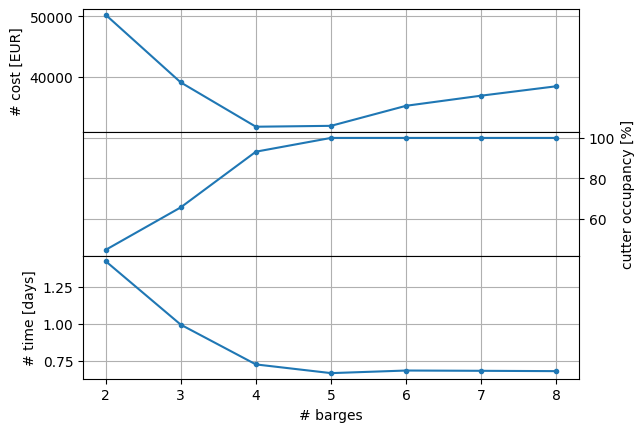

In [7]:
# plot 3 optimization criteria: cost, duration, occupancy (1/flexibility)
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(scenarios['# barges'],scenarios['total cost'],'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(scenarios['# barges'],scenarios['cutter occupancy'],'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(scenarios['# barges'],scenarios['total duration'],'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

## Example plots for 1 chosen scenario

In [8]:
# choose 1 scenario for further analysis and export
# many barges: close to 100% cutter config, small cost, fast delivery.
scenario_index = 2

In [9]:
vessels = results[scenario_index]['vessels']
sites = results[scenario_index]['sites']
activities = results[scenario_index]['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]
scenarios[scenarios.index==scenario_index]

,# barges,cutter occupancy,total cost,total duration
2,4,93.2,31793.0,0.725116


In [10]:
# determine occupamncy per vessel

occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost).sort_values(by=["name"])

,# trips,start,finish,amount sum,duration actual,duration theory,cost actual,production actual,production theory,occupancy [%]
name,,,,,,,,,,
Barge I,6,1970-01-01 00:00:00,1970-01-01 17:24:10,26.0,62650.0,57642.0,3626.0,0.002490,0.002706,92.0
Carrier A,5,1970-01-01 00:00:00,1970-01-01 16:18:30,25.0,58710.0,52235.0,4077.0,0.002129,0.002393,89.0
Carrier B,5,1970-01-01 00:00:00,1970-01-01 15:13:15,25.0,54795.0,48725.0,3805.0,0.002281,0.002565,88.9
Carrier C,6,1970-01-01 00:00:00,1970-01-01 16:34:20,24.0,59660.0,50232.0,4143.0,0.002414,0.002867,84.2
Cutter T,6,1970-01-01 00:35:24,1970-01-01 16:05:12,100.0,55788.0,52000.0,16142.0,0.010755,0.011538,93.2


In [11]:
# activities per vessel

fig = get_gantt_chart(vessels, id_map=activities)

In [12]:
# activities per site and cutter

fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

In [13]:
# Plot only activities whose namespace (first letters) matches load*: 1 activty_type

flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

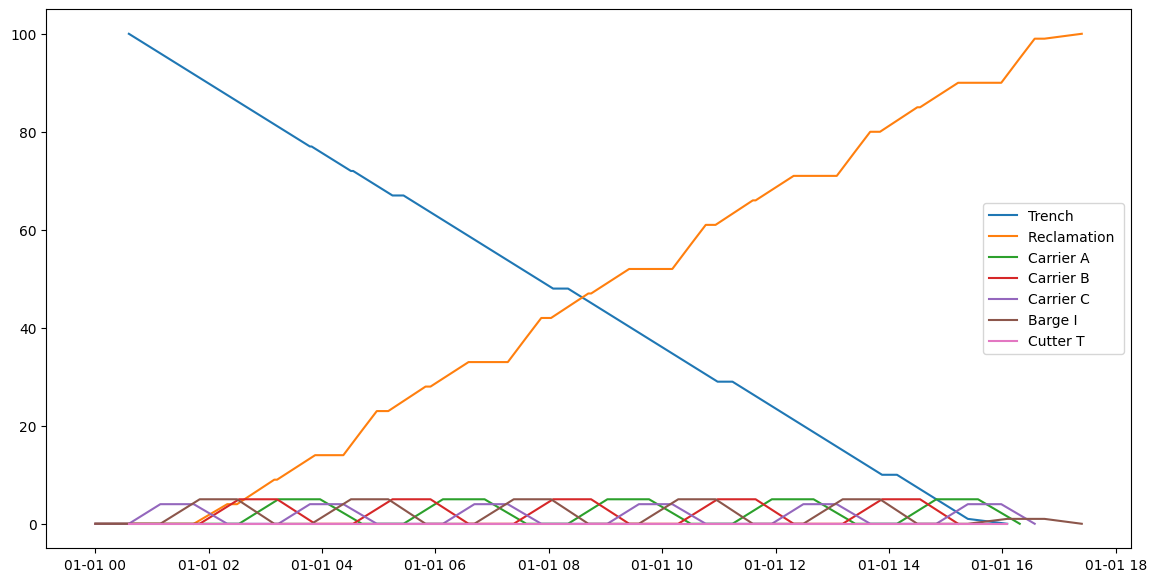

In [14]:
# plot overall amount s-curve

fig = get_step_chart([from_site, to_site, *vessels.values()])

## Export data  to BI for interactive a posteriori analysis

In [15]:
export_concepts(sites, 'site', 'sites.csv')

,siteName,siteID,siteType
0,Trench,05662201-fd19-4993-b9e7-45143fa67dd7,<class '__main__.Site'>
1,Reclamation,bd86fa23-b8ad-4ff4-ac37-40d2b1a69188,<class '__main__.Site'>


In [16]:
export_concepts(vessels, 'vessel', 'vessels.csv')

,vesselName,vesselID,vesselType
0,Carrier A,febb8576-850b-49e0-ba41-a1c91a09dd7d,<class '__main__.TransportProcessingResource'>
1,Carrier B,fee60757-2ed4-48be-92f2-b07898c621e2,<class '__main__.TransportProcessingResource'>
2,Carrier C,345c4b8f-b72a-40f5-9c8b-e8d8cdbccf89,<class '__main__.TransportProcessingResource'>
3,Barge I,0436a5e0-ed4f-48dc-9604-ed7c6f5aab95,<class '__main__.TransportProcessingResource'>
4,Cutter T,cd838b4e-e6b2-4d2f-b4c9-54d43fcd323d,<class '__main__.TransportProcessingResource'>


In [17]:
export_concepts(vessels, 'vessel', 'vessels.csv')

,vesselName,vesselID,vesselType
0,Carrier A,febb8576-850b-49e0-ba41-a1c91a09dd7d,<class '__main__.TransportProcessingResource'>
1,Carrier B,fee60757-2ed4-48be-92f2-b07898c621e2,<class '__main__.TransportProcessingResource'>
2,Carrier C,345c4b8f-b72a-40f5-9c8b-e8d8cdbccf89,<class '__main__.TransportProcessingResource'>
3,Barge I,0436a5e0-ed4f-48dc-9604-ed7c6f5aab95,<class '__main__.TransportProcessingResource'>
4,Cutter T,cd838b4e-e6b2-4d2f-b4c9-54d43fcd323d,<class '__main__.TransportProcessingResource'>


In [18]:
activities_flat = export_activities(activities, 'activities.csv')
len(activities_flat)

24

In [19]:
activities_log = export_activity_log(activities, 'instances.csv')
len(activities_log)

224

In [20]:
activity_resources =  export_activity_resources(activities, 'resources.csv')
len(activity_resources)

40

## Verification/sanity checks

In [21]:
set(activities_flat['MoverName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C'}

In [22]:
set(activities_flat['ProcessorName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Cutter T'}

In [23]:
set(activities_flat['OriginName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Trench'}

In [24]:
set(activities_flat['DestinationName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Reclamation', 'Trench'}

In [25]:
set(activities_flat['ActivityClass'])

{'MoveActivity', 'SequentialActivity', 'ShiftAmountActivity', 'WhileActivity'}

In [26]:
set(activities_flat['OriginName'])

{'', 'Barge I', 'Carrier A', 'Carrier B', 'Carrier C', 'Trench'}

In [27]:
set(activity_resources['ConceptMode'])

{'destination', 'mover', 'origin', 'processor'}

# Visualize critical path of chosen optimal scenario

In [28]:
# For explanation of Critical Path see notebook 30
from openclsim.plot.critical_path import CpLog
my_objects = list(vessels.values()) + list(sites.values())
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
occupancy = occupancy_analysis(vessels, cutter_name, total_amount, vessel_cost)

t = f'{cutter_name} occupancy: ' + str(occupancy.loc[cutter_name]['occupancy [%]']) + f'duration actual: ' +\
     str(occupancy.loc[cutter_name]['duration actual'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')